In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.metrics import silhouette_score
import cloudpickle
from sklearn.decomposition import PCA, TruncatedSVD
from numpy.linalg import norm
import warnings
warnings.filterwarnings("ignore")
from sentence_transformers import SentenceTransformer

In [2]:
data = pd.read_json(os.path.join("..", "data", "News_Category_Dataset_v3.json"), lines=True)

In [3]:
data.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [4]:
# CONSIDERING 50000 SAMPLES
data = data.iloc[:50000, :].copy()

In [5]:
data.category.value_counts()

POLITICS          17399
ENTERTAINMENT      6508
WORLD NEWS         3299
QUEER VOICES       2035
COMEDY             1934
HEALTHY LIVING     1605
BLACK VOICES       1498
PARENTS            1390
U.S. NEWS          1377
THE WORLDPOST      1347
WOMEN              1331
MEDIA              1089
SPORTS             1014
WEIRD NEWS          883
CRIME               842
GREEN               634
ARTS & CULTURE      611
BUSINESS            606
STYLE               595
TASTE               587
RELIGION            464
IMPACT              453
LATINO VOICES       419
TRAVEL              370
EDUCATION           293
TECH                229
SCIENCE             177
STYLE & BEAUTY      165
HOME & LIVING       125
ENVIRONMENT         121
WELLNESS            118
FOOD & DRINK        114
PARENTING           114
COLLEGE              64
MONEY                49
CULTURE & ARTS       44
GOOD NEWS            40
WORLDPOST            35
ARTS                 12
FIFTY                 8
WEDDINGS              2
Name: category, 

In [6]:
data.to_parquet(os.path.join("..", "data", "text_data.parquet"))

In [7]:
data['description'] = data['headline'] + " " + data['short_description']

In [8]:
data = data['description'].copy()

In [9]:
data

0        Over 4 Million Americans Roll Up Sleeves For O...
1        American Airlines Flyer Charged, Banned For Li...
2        23 Of The Funniest Tweets About Cats And Dogs ...
3        The Funniest Tweets From Parents This Week (Se...
4        Woman Who Called Cops On Black Bird-Watcher Lo...
                               ...                        
49995    GOP Elector Decides To Resign From Electoral C...
49996    Dana Rohrabacher Really Doesn't Want To Lose T...
49997    Why I Will Never Teach My Mannequin Kids The M...
49998    Here's A Great Way To Explain What Transgender...
49999    Powerful Photos Show The Scene At Standing Roc...
Name: description, Length: 50000, dtype: object

In [10]:
class TextPreprocessor:
    def __init__(self, lemmatize: bool = True, remove_punct: bool = True, remove_digits: bool = True,
                 remove_stop_words: bool = True,
                 remove_short_words: bool = True, minlen: int = 1, maxlen: int = 1, top_p: float = None,
                 bottom_p: float = None):
        self.lemmatize = lemmatize
        self.remove_punct = remove_punct
        self.remove_digits = remove_digits
        self.remove_stop_words = remove_stop_words
        self.remove_short_words = remove_short_words
        self.minlen = minlen
        self.maxlen = maxlen
        self.top_p = top_p
        self.bottom_p = bottom_p
        self.words_to_remove = []
        self.stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
                           "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
                           'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
                           'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll",
                           'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has',
                           'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
                           'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',
                           'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
                           'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
                           'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
                           'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
                           'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've",
                           'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
                           'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven',
                           "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
                           "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
                           'won', "won't", 'wouldn', "wouldn't"]

    @staticmethod
    def __remove_double_whitespaces(string: str):
        return " ".join(string.split())

    @staticmethod
    def __lemmatize(string_series: pd.Series):
        nlp = spacy.load(os.path.join("..", "en_core_web_sm-3.4.1"))

        def str_lemmatize(string: str):
            doc = nlp(string)
            return " ".join([token.lemma_ for token in doc])

        return string_series.map(str_lemmatize)

    def __remove_punct(self, string_series: pd.Series):
        clean_string_series = string_series.str.replace(pat=f'[{string.punctuation}]', repl=" ", regex=True).copy()
        return clean_string_series.map(self.__remove_double_whitespaces)

    def __remove_digits(self, string_series: pd.Series):
        clean_string_series = string_series.str.replace(pat=r'\d', repl=" ", regex=True).copy()
        return clean_string_series.map(self.__remove_double_whitespaces)

    @staticmethod
    def __remove_short_words(string_series: pd.Series, minlen: int = 1, maxlen: int = 1):
        clean_string_series = string_series.map(lambda string: " ".join([word for word in string.split() if
                                                                         (len(word) > maxlen) or (len(word) < minlen)]))
        return clean_string_series

    def __remove_stop_words(self, string_series: pd.Series):
        def str_remove_stop_words(string: str):
            stops = self.stop_words
            return " ".join([token for token in string.split() if token not in stops])

        return string_series.map(str_remove_stop_words)

    def __remove_top_bottom_words(self, string_series: pd.Series, top_p: int = None,
                                  bottom_p: int = None, dataset: str = 'train'):
        if dataset == 'train':
            if top_p is None:
                top_p = 0
            if bottom_p is None:
                bottom_p = 0

            if top_p > 0 or bottom_p > 0:
                word_freq = pd.Series(" ".join(string_series).split()).value_counts()
                n_words = len(word_freq)

            if top_p > 0:
                self.words_to_remove.extend([*word_freq.index[: int(np.ceil(top_p * n_words))]])

            if bottom_p > 0:
                self.words_to_remove.extend([*word_freq.index[-int(np.ceil(bottom_p * n_words)):]])

        if len(self.words_to_remove) == 0:
            return string_series
        else:
            clean_string_series = string_series.map(lambda string: " ".join([word for word in string.split()
                                                                             if word not in self.words_to_remove]))
            return clean_string_series

    def preprocess(self, string_series: pd.Series, dataset: str = "train"):
        string_series = string_series.str.lower().copy()
        if self.lemmatize:
            string_series = self.__lemmatize(string_series=string_series)
        if self.remove_punct:
            string_series = self.__remove_punct(string_series=string_series)
        if self.remove_digits:
            string_series = self.__remove_digits(string_series=string_series)
        if self.remove_stop_words:
            string_series = self.__remove_stop_words(string_series=string_series)
        if self.remove_short_words:
            string_series = self.__remove_short_words(string_series=string_series,
                                                      minlen=self.minlen,
                                                      maxlen=self.maxlen)
        string_series = self.__remove_top_bottom_words(string_series=string_series,
                                                       top_p=self.top_p,
                                                       bottom_p=self.bottom_p, dataset=dataset)

        string_series = string_series.str.strip().copy()
        string_series.replace(to_replace="", value="this is an empty message", inplace=True)

        return string_series

In [11]:
class TextVectorizer:
    '''
    Huggingface sentence transformers to extract sentence embeddings
    '''
    def vectorize(self, x: pd.Series, dataset: str = "train"):
        x = x.copy()
        model = SentenceTransformer('bert-base-nli-mean-tokens')
        sen_embeddings = model.encode(x)
        return sen_embeddings

In [12]:
class DimensionalityReduction:
    '''
    Reducing dimensions of sentence embeddings for quicker processing and less memory usage
    '''
    def __init__(self, n_components: int):
        self.n_components = n_components
        self.pca = None
        self.tsvd = None
        self.minmax = None
        self.maxabs = None

    def reduce_dimensions(self, x, dataset: str = "train"):
        x = x.copy()
        if not isinstance(x, pd.DataFrame) and not isinstance(x, np.ndarray):
            if dataset == "train":
                self.maxabs = MaxAbsScaler()
                self.maxabs.fit(x)
                x = self.maxabs.transform(x).copy()
                self.tsvd = TruncatedSVD(n_components=self.n_components, random_state=42)
                self.tsvd.fit(x)
            if dataset != "train":
                x = self.maxabs.transform(x).copy()
            x = self.tsvd.transform(x).copy()
        else:
            if dataset == "train":
                self.minmax = MinMaxScaler()
                self.minmax.fit(x)
                x = self.minmax.transform(x).copy()
                self.pca = PCA(n_components=self.n_components, random_state=42)
                self.pca.fit(x)
            if dataset != "train":
                x = self.minmax.transform(x).copy()
            x = self.pca.transform(x).copy()
        return x

In [13]:
class Cluster():
    '''
    Clustering the similar vectorized sentences together 
    '''
    
    def __init__(self, min_cluster:int = 2, max_cluster:int = 10, random_state:int = 42):
        self.scaler = None
        self.k = None
        self.min_cluster = min_cluster
        self.max_cluster = max_cluster
        self.kmeans_model = None
        self.random_state = random_state
        
    def __fit_scaler(self, X):
        self.scaler = MinMaxScaler()
        self.scaler.fit(X)
        
    def __find_best_k(self, X):
        self.__fit_scaler(X)
        X_scaled = self.scaler.transform(X)
        silhouette_scores = []
        for k in range(self.min_cluster, self.max_cluster + 1):
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            kmeans.fit(X_scaled)
            labels = kmeans.labels_
            silhouette_scores.append(silhouette_score(X=X_scaled, labels=labels, random_state=self.random_state))
        self.k = self.min_cluster + np.argmax(silhouette_scores)
        
    def fit(self, X):
        self.__find_best_k(X)
        self.kmeans_model = KMeans(n_clusters=self.k, random_state=self.random_state)
        X_scaled = self.scaler.transform(X)
        self.kmeans_model.fit(X_scaled)
        
        
    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        prediction = self.kmeans_model.predict(X_scaled)
        return prediction
    
    def fit_predict(self, X):
        self.fit(X)
        self.predict(X)

In [14]:
# TEXT PREPROCESSING
text_preprocess = TextPreprocessor(lemmatize=False)
preprocessed_text = text_preprocess.preprocess(data)

In [15]:
# SAVING PREPROCESSED TEXT AND PREPROCESS CLASS
pd.DataFrame(preprocessed_text).to_parquet(os.path.join("..", "data", "preprocessed_text.parquet"))
with open(os.path.join("..", "models", "preprocessor.bin"), "wb") as file:
    cloudpickle.dump(text_preprocess, file)

In [16]:
# READING PREPROCESSED TEXT
preprocessed_text = pd.read_parquet(os.path.join("..", "data", "preprocessed_text.parquet")).squeeze("columns")
preprocessed_text

0        million americans roll sleeves omicron targete...
1        american airlines flyer charged banned life pu...
2        funniest tweets cats dogs week sept dog unders...
3        funniest tweets parents week sept accidentally...
4        woman called cops black bird watcher loses law...
                               ...                        
49995    gop elector decides resign electoral college t...
49996    dana rohrabacher really want lose online poll ...
49997    never teach mannequin kids mannequin challenge...
49998    great way explain transgender means kids somet...
49999    powerful photos show scene standing rock get c...
Name: description, Length: 50000, dtype: object

In [17]:
# EXTRACTING SENTENCE EMBEDDINGS FROM HF SENTENCE TRANSFORMERS
vectorizer = TextVectorizer()
vectorized_text = vectorizer.vectorize(preprocessed_text)
pd.DataFrame(vectorized_text, columns=[str(i) for i in range(vectorized_text.shape[1])]).to_parquet(os.path.join("..", "data", "vectorized_text.parquet"))
with open(os.path.join("..", "models", "vectorizer.bin"), "wb") as file:
    cloudpickle.dump(vectorizer, file)

In [18]:
vectorized_text.shape

(50000, 768)

In [19]:
# SAVING VECTORIZED SENTENCE DATA
vectorized_text = pd.read_parquet(os.path.join("..", "data", "vectorized_text.parquet"))
vectorized_text.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.348604,0.224791,0.587835,0.021539,0.936388,-0.522525,-0.265266,0.452338,0.633545,-0.628432,...,-0.349243,-0.645083,-0.749294,-0.639461,0.319237,-0.346626,-0.422148,-0.066128,0.750257,0.736668
1,0.100282,0.765578,0.619608,0.341304,0.055928,-0.463602,0.941963,-0.676753,0.383726,0.254634,...,-0.183254,-0.663993,-1.022537,-1.279540,0.105261,-0.593642,-0.250466,-0.168751,0.023353,-0.095318
2,-0.245373,1.005552,0.508761,-0.059529,-0.283023,-0.551248,0.604396,0.195050,-0.325778,-0.430899,...,-0.575232,-0.107071,-1.357987,-0.844127,0.355204,-1.226387,0.282177,0.297868,1.090589,0.810077
3,-0.299000,1.250460,0.430264,-0.075660,0.280682,-0.379261,0.966618,0.163225,0.390289,-0.179051,...,-0.659211,-0.672255,-1.593885,-0.902628,0.579351,-1.246761,0.198906,-0.040560,0.210218,0.688975
4,0.128596,0.724642,-0.521468,0.151441,0.767574,0.048907,0.960015,-0.063603,0.393527,0.529087,...,-0.584926,-0.758323,-1.717347,-1.232472,0.831796,-1.130401,-0.147202,-0.337285,0.019787,-0.144571


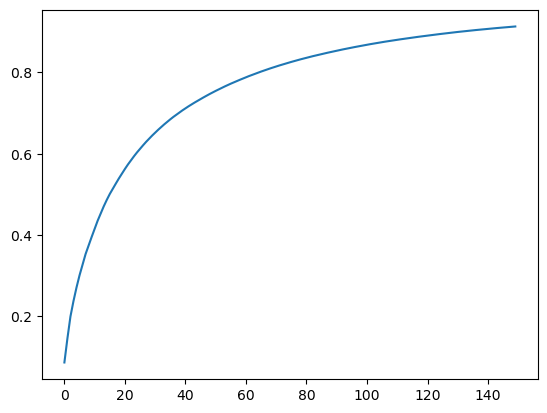

In [20]:
# REDUCING DIMENSIONS OF SENETENCE EMBEDDINGS (VECTORIZED SENTENCES) FROM 768 TO 150 FOR QUICKER PROCESSING
dimensionality_reduction = DimensionalityReduction(n_components=150)
pca_text = dimensionality_reduction.reduce_dimensions(vectorized_text)
plt.plot(np.cumsum(dimensionality_reduction.pca.explained_variance_ratio_))

In [21]:
np.cumsum(dimensionality_reduction.pca.explained_variance_ratio_)[-1] # explained variance ratio of 92.0

0.91326797

In [22]:
# SAVING THE PCA COMPONENTS AND ALSO DIMENSIONALITY REDUCTION OBJECT
pd.DataFrame(pca_text, columns=[str(i) for i in range(pca_text.shape[1])]).to_parquet(os.path.join("..", "data", "pca_text.parquet"))
with open(os.path.join("..", "models", "pca.bin"), "wb") as file:
    cloudpickle.dump(dimensionality_reduction, file)

In [23]:
# READING PCA COMPONENTS
pca_text = pd.read_parquet(os.path.join("..", "data", "pca_text.parquet"))

In [24]:
pca_text.shape

(50000, 150)

In [25]:
# SINCE THERE ARE 30 PROMINENT CLASSES, I'M CLUSTERING DATA INTO 30 CLUSTERS
cluster = Cluster(min_cluster=30, max_cluster=30)
cluster.fit(pca_text)

In [26]:
# SAVING CLUSTERING OBJECT
with open(os.path.join("..", "models", "clustering.bin"), "wb") as file:
    cloudpickle.dump(cluster, file)

In [27]:
# PREDICTING CLUSTERS FOR TRAIN DATA
clusters = cluster.predict(pca_text)
len(clusters), len(pca_text)

(50000, 50000)

In [28]:
len(set(clusters))

30

In [29]:
pd.Series(clusters).sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [30]:
# TRAIN DATA READ THAT WAS PREVIOUSLY SAVED
text_data = pd.read_parquet(os.path.join("..", "data", "text_data.parquet"))

In [31]:
len(text_data)

50000

In [32]:
# ADDING CLUSTERS TO TRAIN SAMPLES SO THAT SAMPLES CAN BE FILTERED USING THE TEST SAMPLE CLUSTER
text_data['cluster'] = clusters

In [33]:
text_data.to_parquet(os.path.join("..", "data", "text_data.parquet"))

In [34]:
text_data['cluster'].unique()

array([22, 25,  1,  8,  3, 24,  5, 19, 11, 26,  7,  6, 17, 29, 16,  0, 14,
       27, 18, 21, 15, 13, 28,  4, 10,  2, 12,  9, 20, 23])

In [35]:
text_data.loc[text_data['cluster'] == 1]

,link,headline,category,short_description,authors,date,cluster
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,1
38,https://www.huffpost.com/entry/african-land-sn...,German Customs Officials Follow Trail Of Slime...,WEIRD NEWS,“Never in the history of the Duesseldorf custo...,,2022-09-16,1
104,https://www.huffpost.com/entry/bear-swimming-p...,Bear Spotted Chilling In California Swimming Pool,U.S. NEWS,"""He's welcome in my yard as long as he doesn't...",Josephine Harvey,2022-09-05,1
134,https://www.huffpost.com/entry/signs-of-teeth-...,6 Signs You’re Grinding Your Teeth At Night (A...,WELLNESS,"Beyond toothaches, there are other common red ...",Jillian Wilson,2022-08-30,1
154,https://www.huffpost.com/entry/fisherman-prehi...,A Fisherman Thought He Caught A Rock. He Snagg...,WEIRD NEWS,The Nebraska man said he initially believed th...,Ben Blanchet,2022-08-27,1
...,...,...,...,...,...,...,...
49635,https://www.huffingtonpost.com/entry/gremlins-...,Gremlins And Leprechaun Join 'Fantastic Beasts...,COMEDY,Ghoulishly goofy.,Ron Dicker,2016-12-02,1
49642,https://www.huffingtonpost.com/entry/rural-cam...,Rural Cambodia Uses Guppy Fish To Fight Mosqui...,HEALTHY LIVING,Villagers keep the guppies in barrels of water...,"Astrid Zweynert, Reuters",2016-12-02,1
49715,https://www.huffingtonpost.com/entry/sing-clip...,Watch A Koala And A Porcupine Sing 'Call Me Ma...,ENTERTAINMENT,"It's a clip from the upcoming ""Sing.""",Matthew Jacobs,2016-12-01,1
49930,https://www.huffingtonpost.com/entry/highly-co...,Highly Contagious Bird Flu Outbreak In Japan P...,HEALTHY LIVING,This is the country's first bird flu outbreak ...,"Ayai Tomisawa and Osamu Tsukimori, Reuters",2016-11-29,1
